# SLT-CE-4: Constant Shift Embedding

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

 <h2 style="background-color:#f0b375;"> Setup </h2>

We start by importing necessary python packages.

In [20]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

import scipy.linalg as la
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

# Fix random seed for reproducibility
np.random.seed(42)

import scipy
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

The number of nodes is hardcoded for simplicity (taken from [2]):

In [21]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [22]:
# initialize data matrix which will be an adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0], pair[1]] = 1
        DATA[pair[1], pair[0]] = 1

Note that DATA specifies an adjacency matrix of the email graph. It's not claimed to be a proper dissimilarity matrix required by CSE algorithm. So, you are allowed to perform any manipulations to construct a suitable (dis-)similarity matrix for the further analysis.

Next we define a class which contains main functionalities - TO BE IMPLEMENTED.

In [23]:
class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        self.PMAT = None
        self.Sc = None # centralized
        self.St = None # S_tilde
        self.Stc = None
        self.Dc = None # centralized
        self.Dt = None # D_tilde
        # Add/change parameters, if necessary.
    
    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """

        # Save data
        self.PMAT = PMAT
        n = PMAT.shape[1]
        
        ## IMPLEMENT THIS METHOD
        
        # Transform PMAT into a dissimilarity matrix
        D = scipy.sparse.csgraph.shortest_path(self.PMAT, method='auto')
        # This automatically sets self-dissimilarities to zero
        D[D == np.inf] = D[D != np.inf].max() + 10
        
        # Test with Katz Index
        #eval_a, evec_a = la.eigh(self.PMAT)
        #beta = 1/max(eval_a)
        #S = np.linalg.pinv(np.eye(n) - beta*self.PMAT) - np.eye(n)
        #D = np.zeros(S.shape)
        #for i in range(n):
        #    for j in range(n):
        #        D[i,j] = S[i,i] + S[j,j] - 2*S[i,j]
        
        # Symmetrization
        Ds = 1/2 * (D + D.T)
        
        # Centralization
        en = np.ones((n,1))
        Q = np.eye(n) - 1/n * np.dot(en, en.T)
        Dc = np.dot(Q, np.dot(Ds, Q))
        self.Dc = Dc
        
        # Compute Gram
        Sc = -1/2 * Dc
        self.Sc = Sc
        
        # Diagonal shift
        evalues, evectors = la.eigh(Sc)
        lmin = evalues.min()
        St = Sc - lmin * np.eye(n)
        self.St = St
        
        # Off-diagonal shift
        Dt = Ds - 2 * lmin * (np.dot(en, en.T) - np.eye(n))
        self.Dt = Dt
        
    def get_embedded_vectors(self, p):
        """
        Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        """
        
        ## IMPLEMENT THIS METHOD
        n = self.Dt.shape[1]
        Q = np.eye(n) - 1/n * np.dot(en, en.T)
        self.Stc = -1/2 * np.dot(Q, np.dot(self.Dt, Q))
        
        evalues, evectors = la.eigh(self.Stc)
        evalues = evalues[::-1]
        evectors = evectors[:, ::-1]
        Xp = np.dot(evectors[:,:p], np.diag(np.sqrt(evalues[:p])))
        return Xp
        

Note: the function $\texttt{shortest_path}$ automatically selects the best method, based on input data, among Floyd-Warshall, Dijkstra, Bellman-Ford and Johnson.


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Constant Shift Embedding**: (Put your answer here)
Let $D$ be a dissimilarity matrix with zero diagonal elements. Constant Shift Embedding can be used to find a Euclidean representation of the pairwise relations while preserving the group structure. 
    - Symmetrization: $D^s=\frac{1}{2}(D+D^\top)$.
    - Centralization: $D^c=QD^sQ$, where $Q=I_n-\frac{1}{n}e_ne_n^{\top}$.
    - $S^c=-\frac{1}{2}D^c$. This means that $S^c$ is uniquely defined by $D^c$.
    - Diagonal shift: $\tilde{S}=S^c-\lambda_n(S^c)I_n$, where $\lambda_n(S^c)$ is the smallest eigenvalue of $S^c$. This is because $D$ derives from a squared Euclidean distance $\iff$ $S^c\succeq 0$ (Theorem 1 in [1]). The diagonal shift corresponds to an off-diagonal shift of the dissimilarities: $\tilde{D}=D^s-2\lambda_n(S^c)(e_ne_n^{\top}-I_n)$, where $-2\lambda_n(S^c)$ is the minimal constant such that $\tilde{D}$ derives from squared Euclidean distance.
    
    To reconstruct vector embeddings:
    - Calculate the centralized dot product matrix: $\tilde{S}^c=-\frac{1}{2}Q\tilde{D}Q$;
    - Eigendecomposition: $\tilde{S}^c=V\Lambda V^\top$;
    - $X_p=V_p(\Lambda_p)^{1/2}$, whose rows contain the vectors $\{x_i\}_{i=1}^n$ in $p$ dimensional space.

<p style="background-color:#adebad;">
    Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.
</p>    

In [24]:
CSE = ConstantShiftEmbedding()

<p style="background-color:#adebad;">
    Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].
</p>    

In [25]:
CSE.fit(DATA)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.
</p>

In [26]:
## Compute eigen-spectrum
n = CSE.Dt.shape[1]
en = np.ones((n,1))
Q = np.eye(n) - 1/n * np.dot(en, en.T)
Stc = -1/2 * np.dot(Q, np.dot(CSE.Dt, Q))
evalues, evectors = la.eigh(Stc)
evalues = evalues[::-1]
evectors = evectors[:, ::-1]

In [27]:
## Determine a good cut-off value (and write some lines to explain your choice)
p_opt = 25 ## change accordingly
print("Chosen cut-off value is: ", p_opt)

Chosen cut-off value is:  25


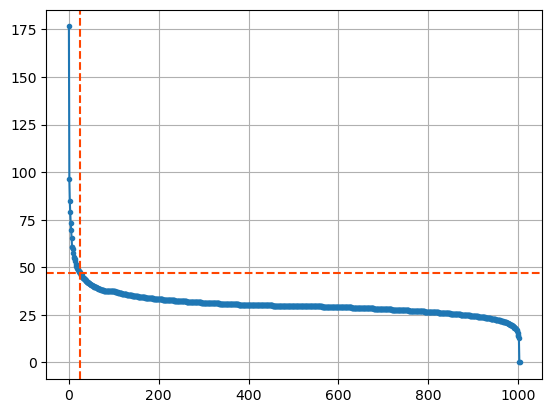

In [28]:
## Plot spectrum and indicate the cut-off value on the spectrum
plt.plot(evalues, marker='.')
plt.axhline(evalues[p_opt], linestyle='--', color='orangered')
plt.axvline(p_opt, linestyle='--', color='orangered')
plt.grid(True)

We want to choose a value for $p$ such that the eigenvalues that are discarded start decreasing at a slower rate. By looking at the plot, this seems to happen after the $25$-th eigenvalue. In particular, the discarded components are considered as noise, while the retained components are considered to be signal, since their eigenvalues are larger. Hence, it is important not to choose $p^∗$ too large, because otherwise we would include noise, and to avoid choosing it too small, because otherwise we would discard signal. In the subsequent analysis, I noticed that values between $20$ and $30$ gave comparable results and chose $25$ accordingly.

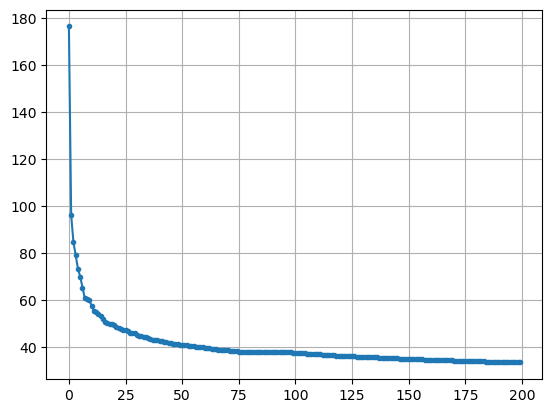

In [29]:
# Zoom in to choose the best value of p
plt.plot(evalues[:200], marker='.')
plt.grid(True)

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Plot the distance matrices both for the denoised ($p = p^*$ -- from the previous step) and the original versions as shown in figure 5 in [1]. Note that the distance matrix is a matrix with pairwise distances between every two points from the dataset ($d_{ij} = dist(x_i, x_j)$).<br>
    Perform K-MEANS algorithm for varying number of clusters K on the embedded vectors derived from CSE. You may use the sklearn implementation of K-MEANS. To make the aforementioned plots meaningful, sort the nodes according to the cluster belongings for every number of clusters K (see the figure 5). For now, there is no need to include the actual ground truth labels given in [2].
</p>

In [30]:
def to_diss(S) :
    D = np.zeros_like(S)
    n = S.shape[0]
    for i in range(n) :
        for j in range(n) :
            D[i,j] = S[i,i] + S[j,j] - 2*S[i,j]
    return D

In [31]:
## Distance matrices
X_p_opt = CSE.get_embedded_vectors(p_opt)
S_p_opt = np.dot(X_p_opt, X_p_opt.T)
D_p_opt = to_diss(S_p_opt)
X = CSE.get_embedded_vectors(NUM_NODES-1) # subtracting 1 because I take the square root and lambda_min=0
S = np.dot(X, X.T)
D = to_diss(S)

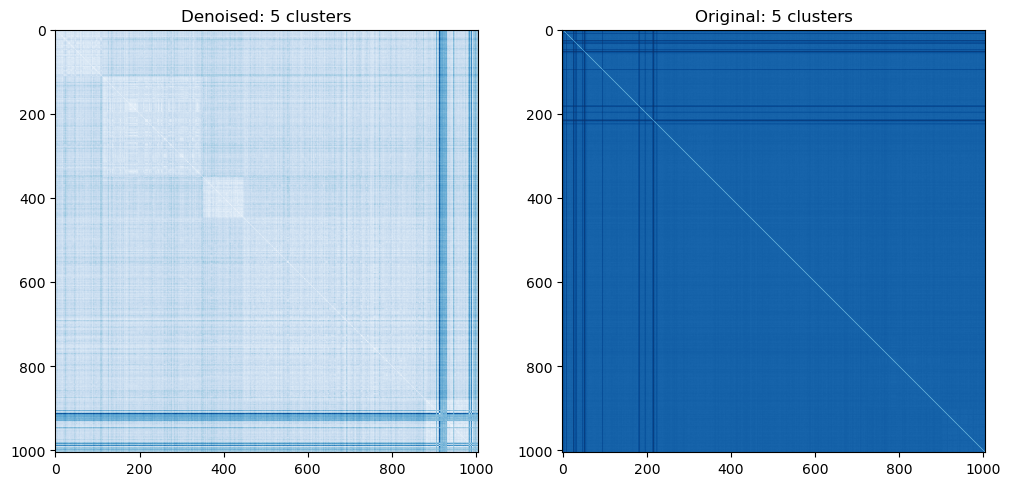

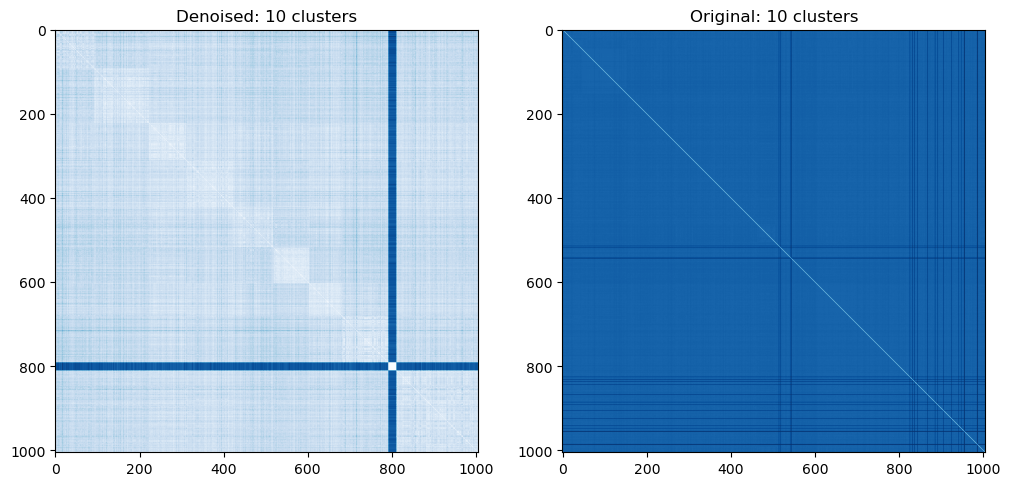

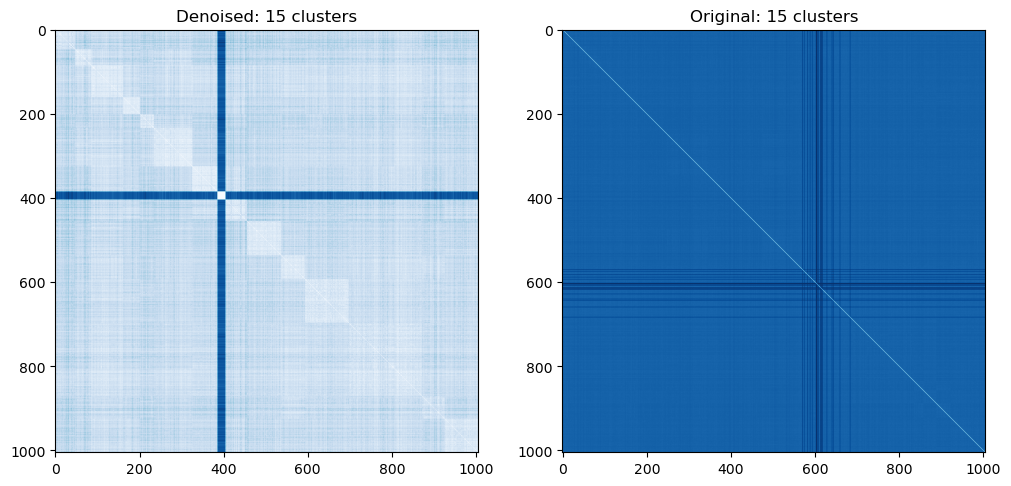

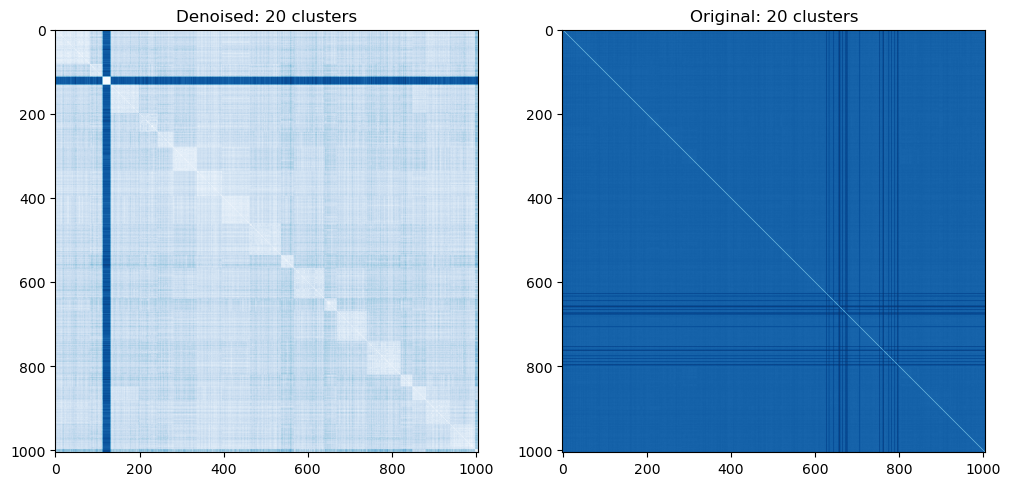

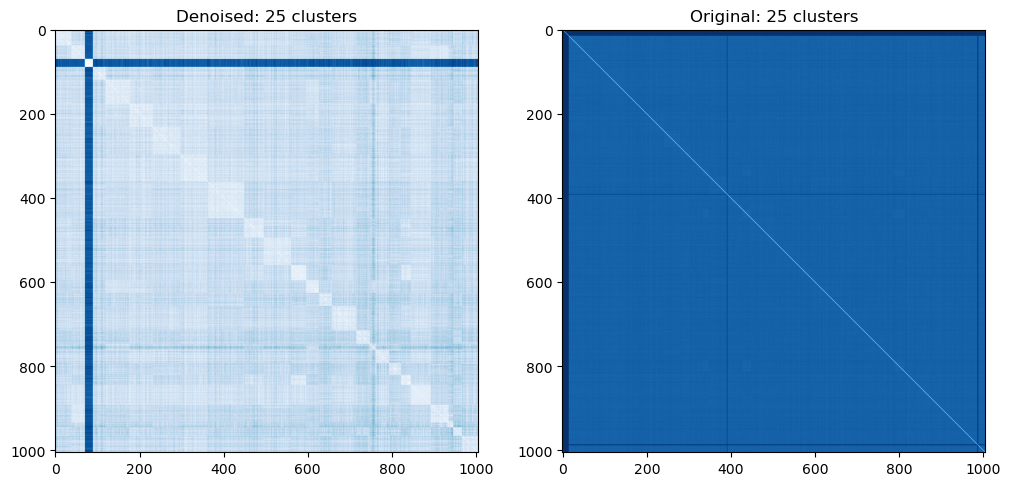

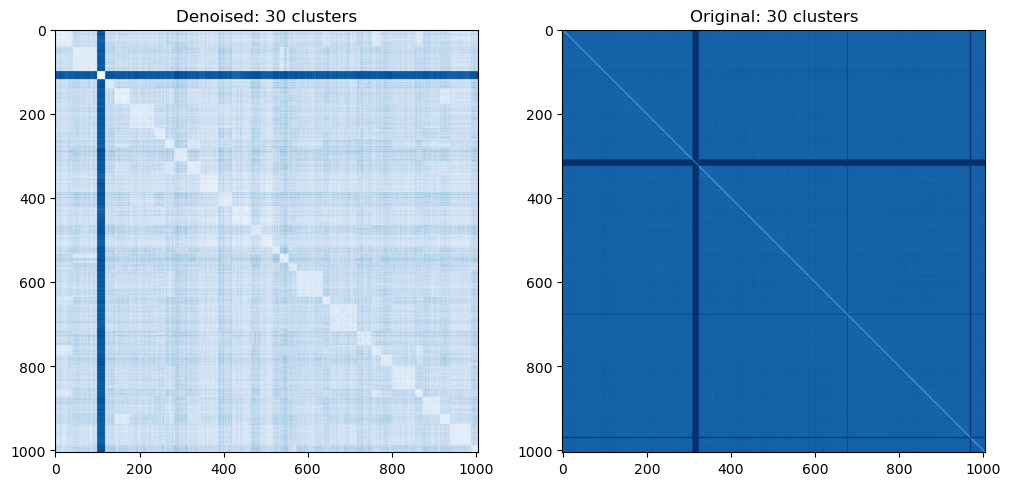

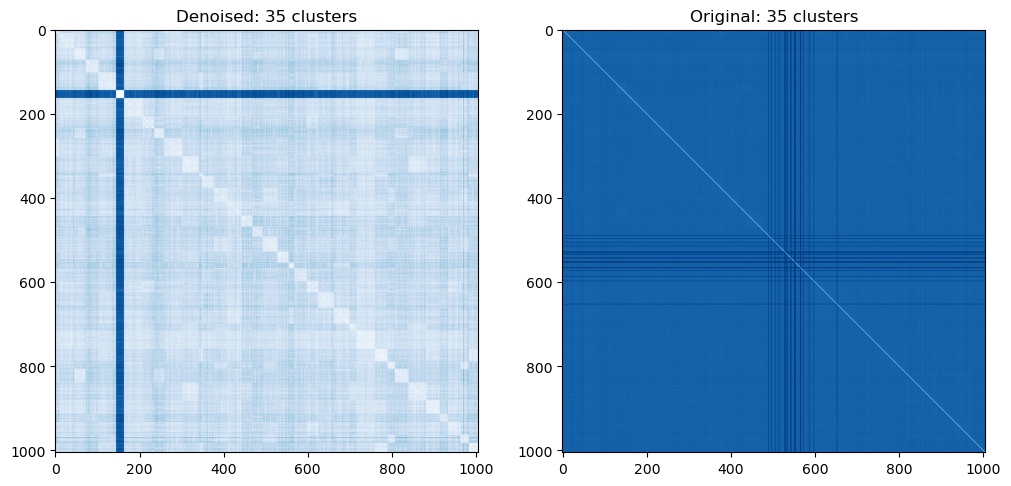

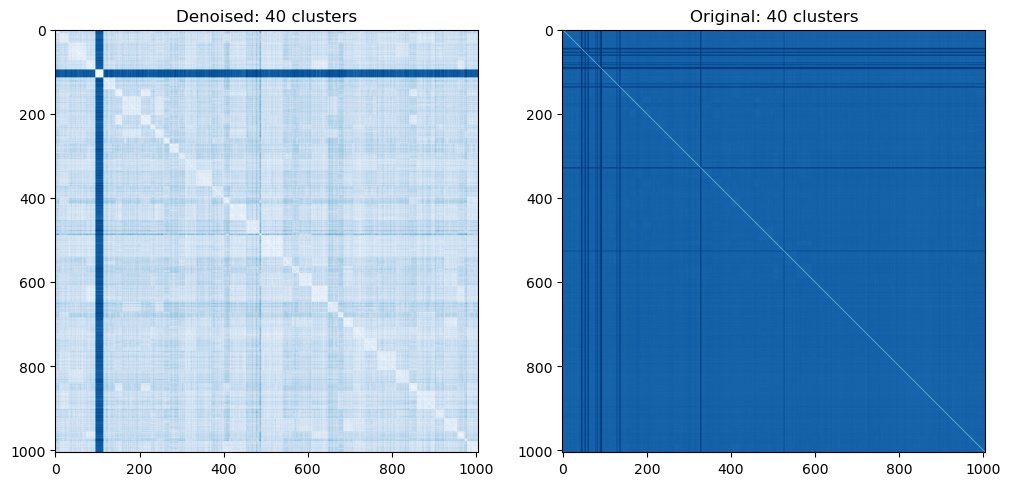

In [56]:
n_clusters = [5, 10, 15, 20, 25, 30, 35, 40]
for nc in n_clusters:
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    km = KMeans(n_clusters=nc, n_init='auto')  
    km.fit(X_p_opt)
    ordering = np.argsort(km.labels_)
    ax[0].imshow(D_p_opt[ordering][:, ordering], cmap='Blues')
    ax[0].set_title(f'Denoised: {nc} clusters')
    
    km = KMeans(n_clusters=nc, n_init='auto')  
    km.fit(X)
    ordering = np.argsort(km.labels_)
    ax[1].imshow(D[ordering][:, ordering], cmap='Blues')
    ax[1].set_title(f'Original: {nc} clusters')
    plt.show()

The original version of the distance matrix shows no apparent cluster structure. This is probably due to the presence of noise, because in the previous section we showed that the number of relevant components is considerably lower than the total number of components. This is further confirmed by the fact that in the denoised version the presence of a cluster structure is evident. 

**Note**: In section 3.1 in [1] the authors point out that $\tilde{D}$ derives from squared Euclidean distances between points $\{x_i\}_{i=1}^n$ in some vector space. So the mutual distances between rows in $X_p$ are given by $\tilde{D}$. In the following I'll show that this is indeed true by calculating first the Euclidean distances and then comparing the matrices.

In [66]:
## Distance matrices
dist_p_opt = skl.metrics.pairwise_distances(X_p_opt)
dist = skl.metrics.pairwise_distances(X)

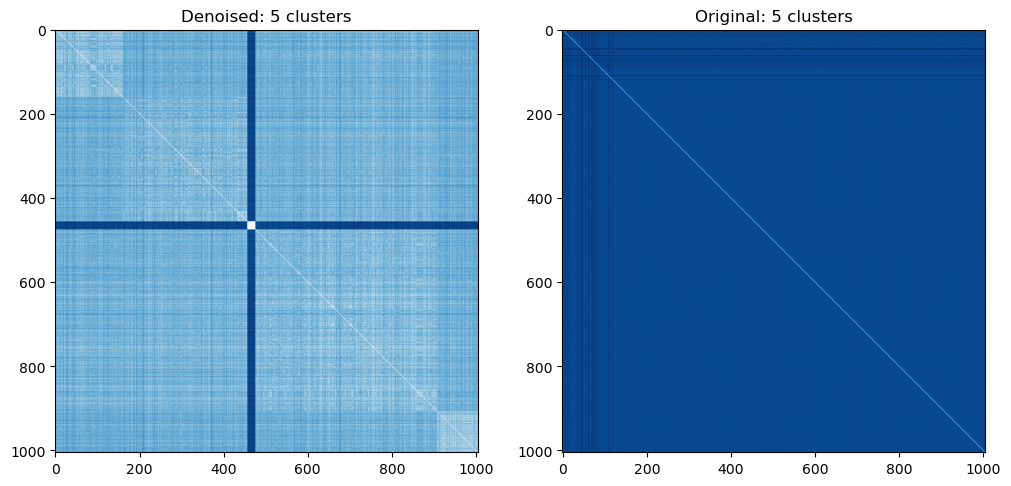

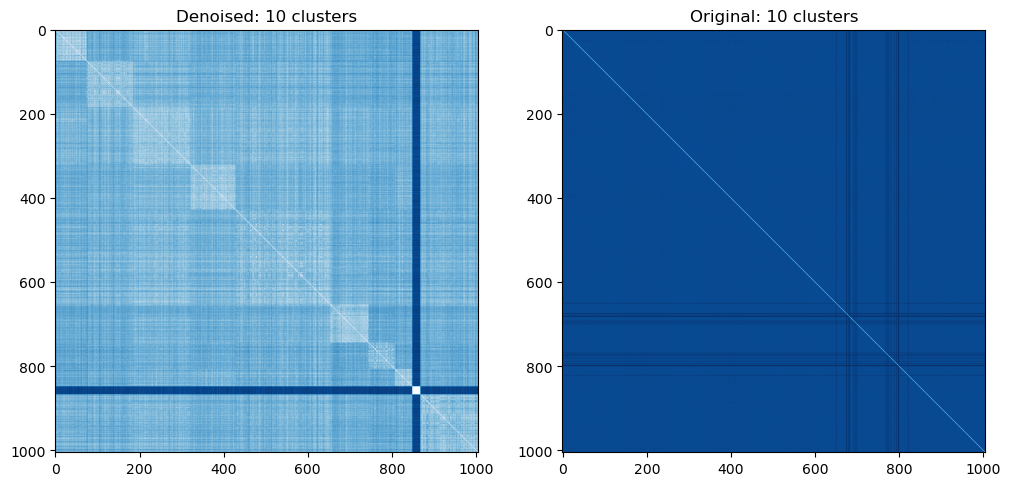

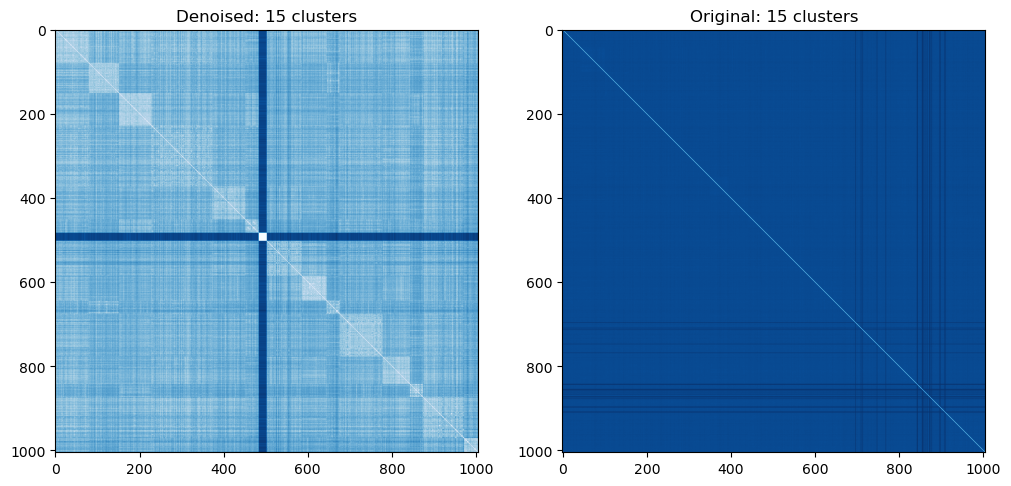

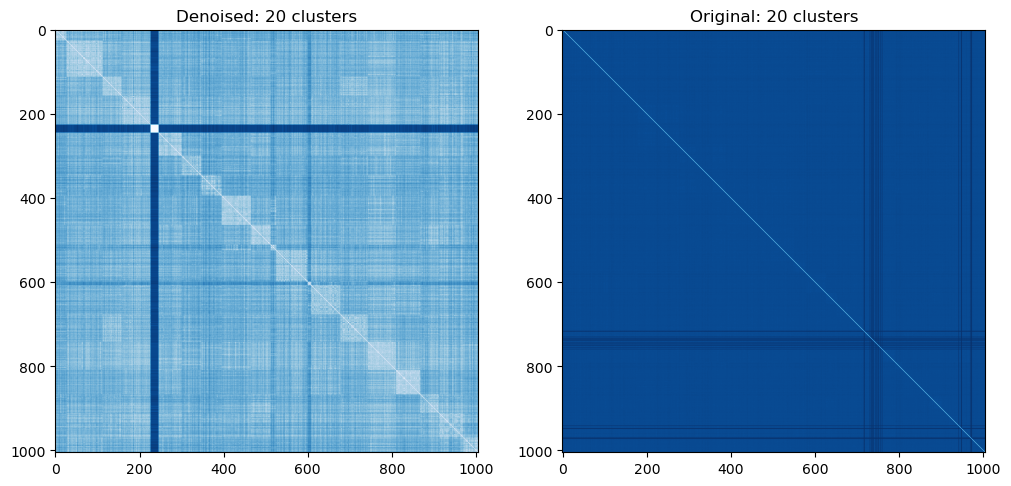

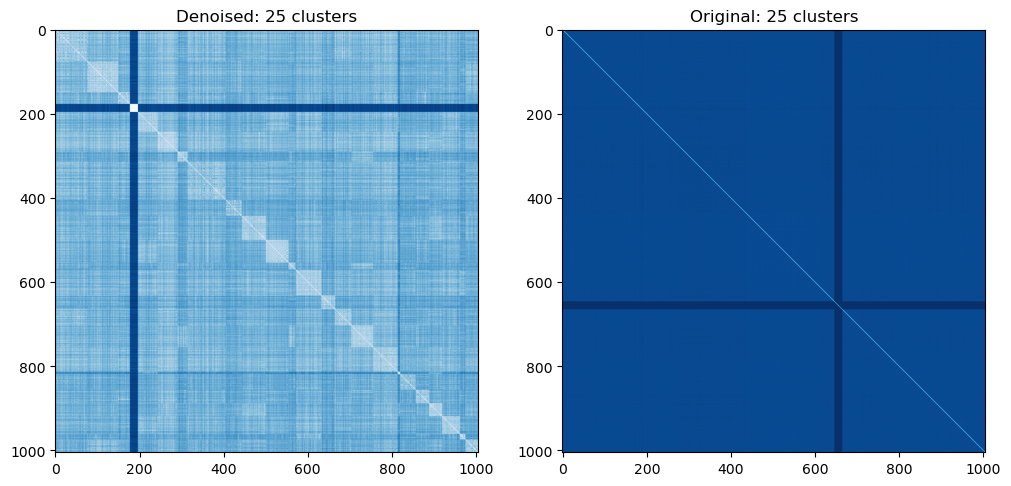

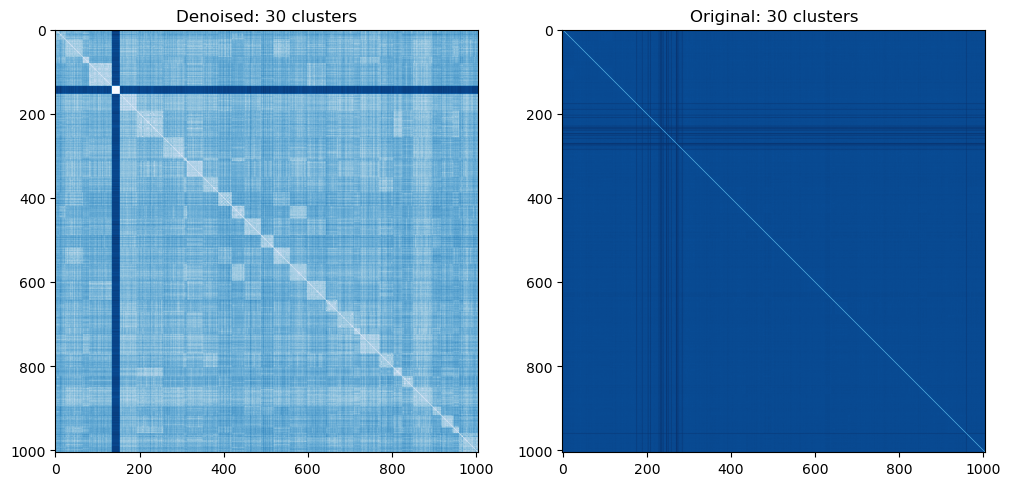

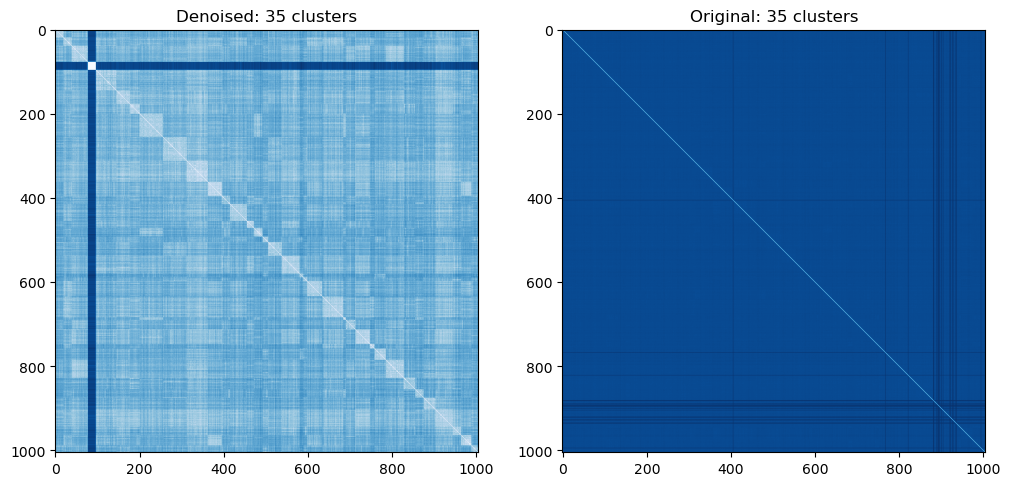

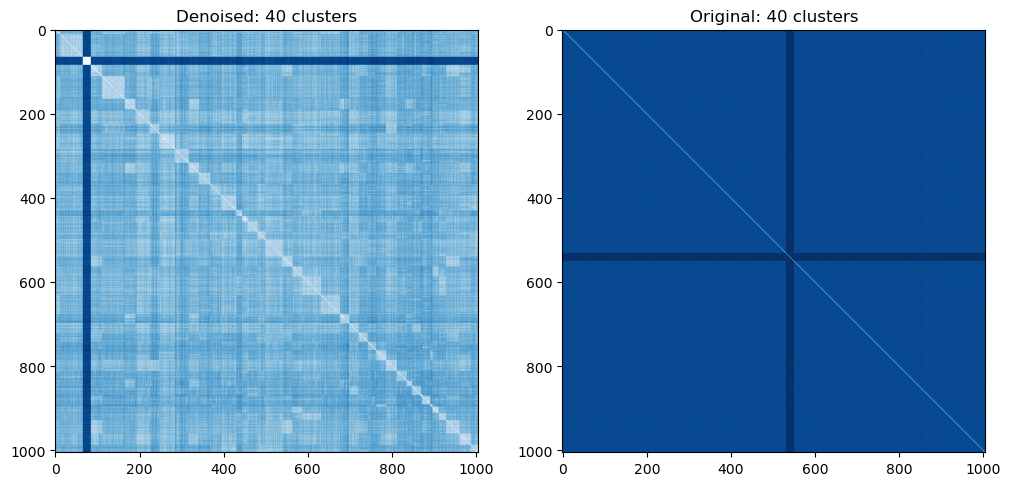

In [67]:
n_clusters = [5, 10, 15, 20, 25, 30, 35, 40]
for nc in n_clusters:
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    km = KMeans(n_clusters=nc, n_init='auto')  
    km.fit(X_p_opt)
    ordering = np.argsort(km.labels_)
    ax[0].imshow(dist_p_opt[ordering][:, ordering], cmap='Blues')
    ax[0].set_title(f'Denoised: {nc} clusters')
    
    km = KMeans(n_clusters=nc, n_init='auto')  
    km.fit(X)
    ordering = np.argsort(km.labels_)
    ax[1].imshow(dist[ordering][:, ordering], cmap='Blues')
    ax[1].set_title(f'Original: {nc} clusters')
    plt.show()

In [68]:
np.allclose(D_p_opt, dist_p_opt**2)

True

In [69]:
np.allclose(D, dist**2)

True

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Now calculate the embeddings for p = 2 (2D case) and p = 3 (3D case) and plot clusterings for a few values of K.  Alternatively, you could use $p = p^*$ for more gentle denoising, cluster the denoised embeddings and only then apply a dimensionality reduction technique to get a plot in 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.
</p>

In [ ]:
## Get embeddings, run K-MEANS and generate plots

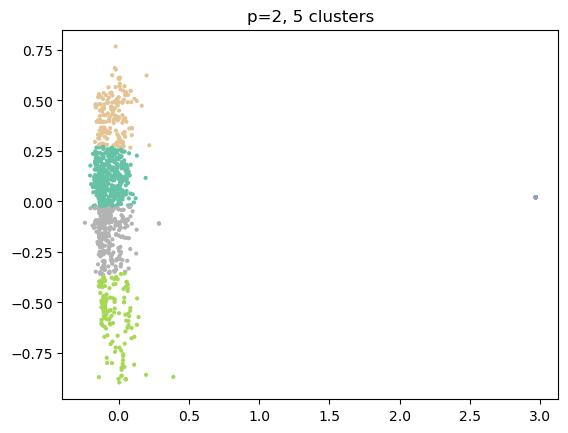

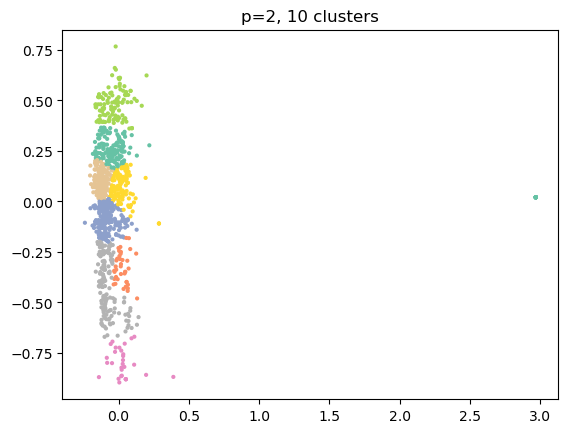

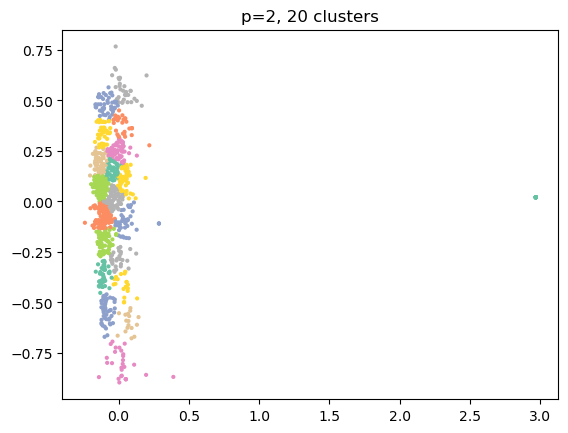

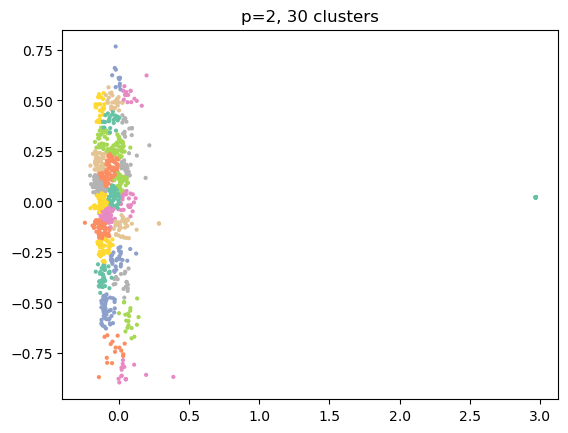

In [70]:
## p = 2
X_2 = CSE.get_embedded_vectors(2)
n_clusters = [5, 10, 20, 30]
for nc in n_clusters:
    km = KMeans(n_clusters=nc, n_init='auto')  
    km.fit(X_2)
    plt.scatter(X_2[:, 0], X_2[:, 1], c=km.labels_, s=4, cmap='Set2')
    plt.title(f'p=2, {nc} clusters')
    plt.show()

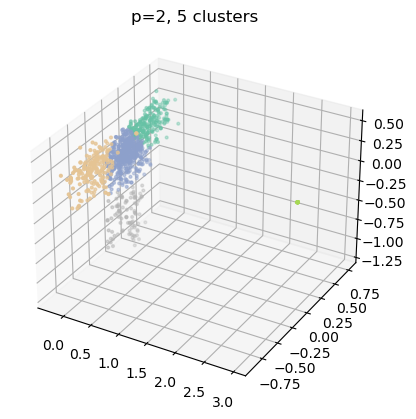

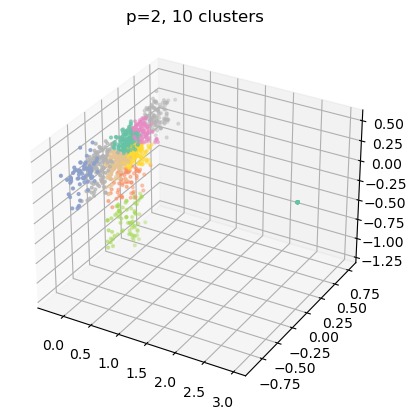

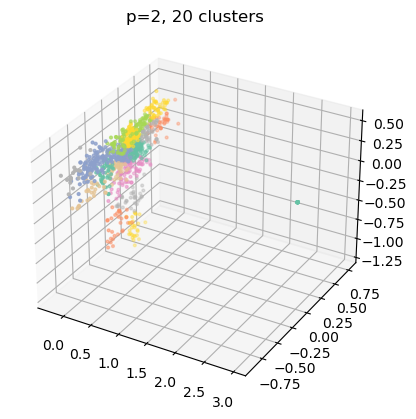

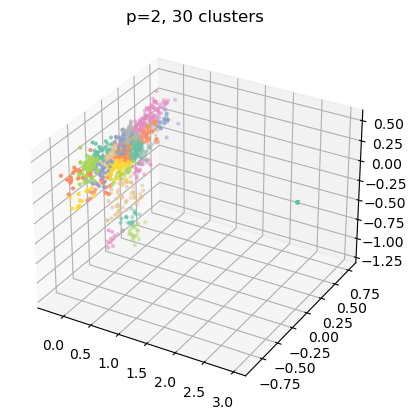

In [71]:
## p = 3
X_3 = CSE.get_embedded_vectors(3)
for nc in n_clusters:
    km = KMeans(n_clusters=nc, n_init='auto')  
    km.fit(X_3)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_3[:, 0], X_3[:, 1], X_3[:, 2], c=km.labels_, s=4, cmap='Set2')
    plt.title(f'p=2, {nc} clusters')
    plt.show()

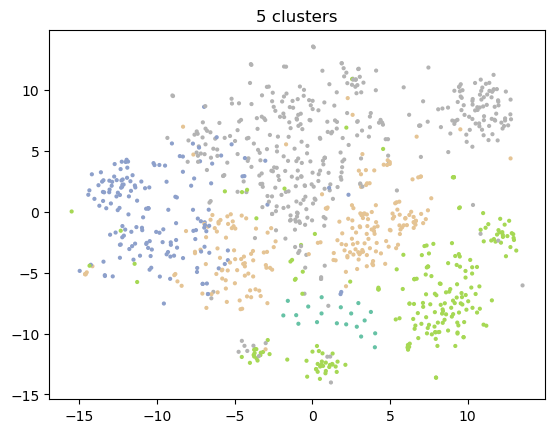

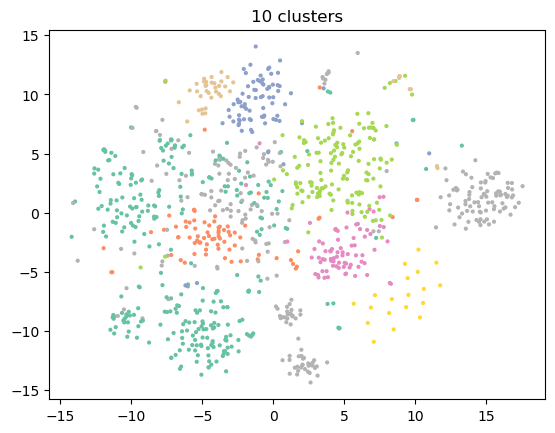

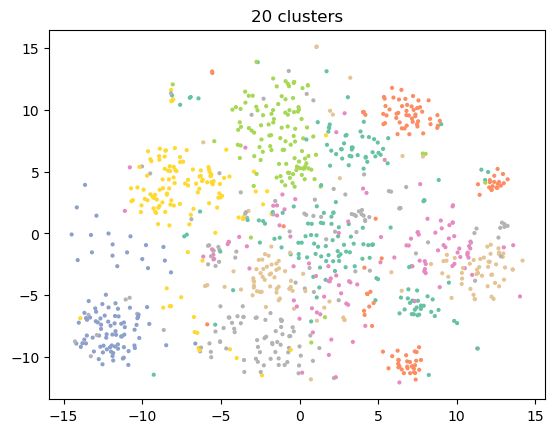

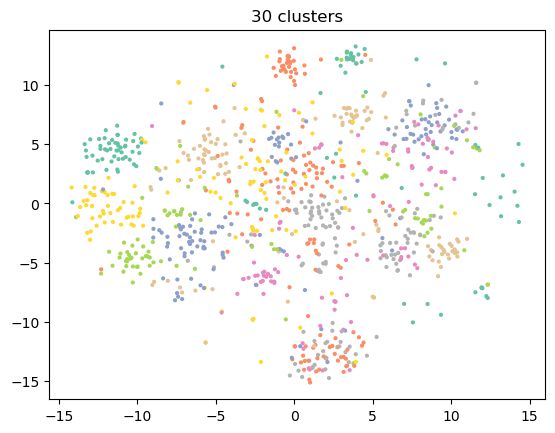

In [72]:
## choose p > 3, for example, p = p_opt, to compute CSE embeddings 
## First, cluster the computed p-dimensional embeddings and then project them onto 2-dimensional space 
## for visualization using PCA, LL, t-SNE or something else
X_p_opt = CSE.get_embedded_vectors(p_opt)
for nc in n_clusters:
    km = KMeans(n_clusters=nc, n_init='auto')  
    km.fit(X_p_opt)
    X_embedded = skl.manifold.TSNE(n_components=2).fit_transform(X)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=km.labels_, s=4, cmap='Set2')
    plt.title(f'{nc} clusters')
    plt.show()

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2]. You can reuse code from the previous coding exercises to align the cluster labels with the ground truth.
</p>

In [73]:
# Initialize community members affiliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))

The true number of clusters (departments) is:  42


<p style="background-color:#adebad;">
Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?
</p>

In [ ]:
## Here you can provide plots and calculations

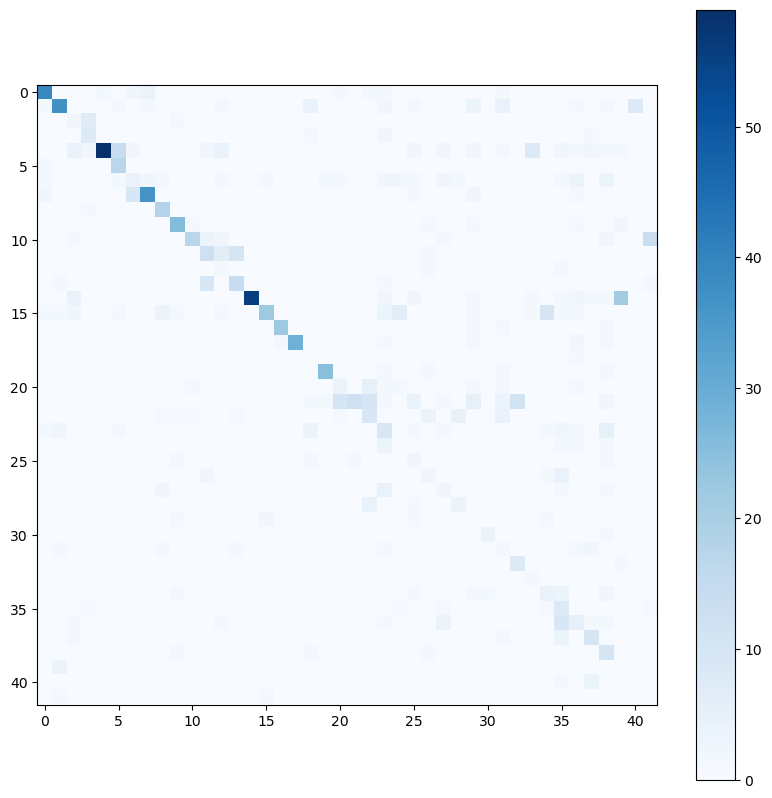

In [74]:
X_p_opt = CSE.get_embedded_vectors(30)
dist_p_opt = skl.metrics.pairwise_distances(X_p_opt)
km = KMeans(n_clusters=42, n_init='auto', random_state=37)  
km.fit(X_p_opt)
confmat = skl.metrics.confusion_matrix(AFFILIATIONS, km.labels_)
row_idx, col_idx = scipy.optimize.linear_sum_assignment(confmat, maximize=True)
confmat_permuted = confmat[row_idx,:][:,col_idx]
plt.figure(figsize=(10,10))
plt.imshow(confmat_permuted, cmap='Blues')
plt.colorbar()

In [75]:
skl.metrics.adjusted_rand_score(AFFILIATIONS, km.labels_)

0.4327680310578343

In [76]:
np.sum(np.diag(confmat_permuted))/np.sum(confmat_permuted)

0.5333333333333333

This is the same as:

In [77]:
mapping = dict(zip(col_idx, row_idx))
labels_permuted = list(map(lambda x: mapping[x], km.labels_))
skl.metrics.accuracy_score(AFFILIATIONS, labels_permuted)

0.5333333333333333

Text(0.5, 1.0, 'KMeans, 42 clusters')

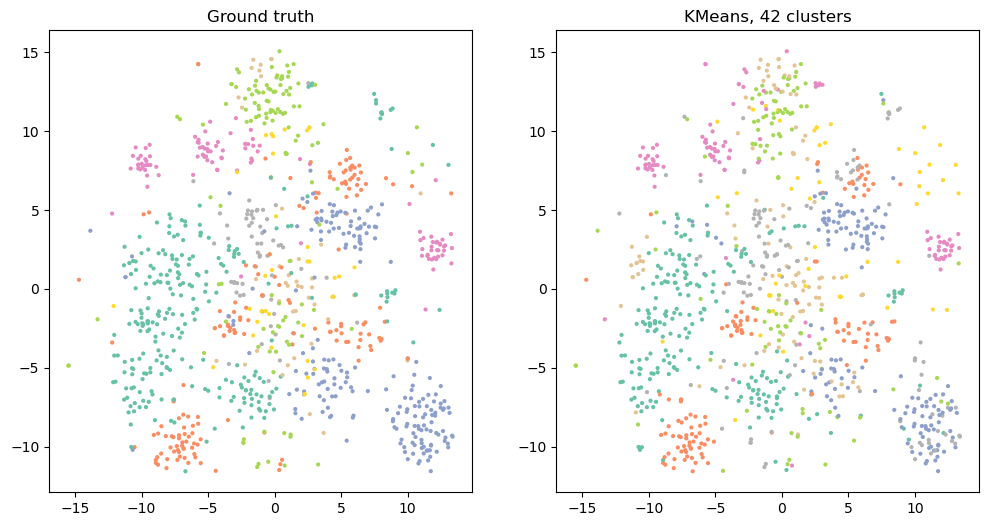

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
X_embedded = skl.manifold.TSNE(n_components=2).fit_transform(X)
ax[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=AFFILIATIONS, s=4, cmap='Set2')
ax[0].set_title('Ground truth')
ax[1].scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_permuted, s=4, cmap='Set2')
ax[1].set_title('KMeans, 42 clusters')

Please, write here your explanations, observation and thoughts about results of the experiments above.

In order to assess the quality of the clustering procedure I used both the ARI (Adjusted Rand Index) and the accuracy. The ARI performs the comparison by counting the pairs of observations that are assigned to the same or different clusters in the two partitions. The adjustment is made with respect to a random partition. The ARI takes on a value maximum value of one when there is perfect agreement between the partitions identified, while takes on even negative values when the partition obtained is worse than that obtained from a random classification. The obtained ARI is $0.43$, meaning that the clustering procedure is better than random guessing.
By looking at the plots we notice overlapping between the two groupings, and in particular denser groups are more easily classified. We know that with t-SNE similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. From the plot above, we notice that the misclassified points are in particular among the more isolated data points, which means that they represent individuals that do not have strong connections with any particular group.
In order to improve the accuracy, I tried to use different dissimilarity measures. In particular, among the similarity measures that are listed [here](https://cran.r-project.org/web/packages/linkprediction/vignettes/proxfun.html), I tried implementing the Jaccard index, the Katz index, the Leicht-Holme-Newman index and the Adamic–Adar index, but none of them led to improvements of the clustering procedure compared to the shortest path. I also tried to implement the overlap coefficient described [here](https://towardsdatascience.com/similarity-measures-and-graph-adjacency-with-sets-a33d16e527e1), but it led to similar results if compared to the shortest path method.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.